## Tweet disaster prediction

---

Twitter has recently become one of the most important means of communication when an emergency takes place. The use of smartphones allows people to report an emergency that is occurring in real time. Therefore, there is a marked interest in monitoring Twitter and knowing how to automatically predict whether a real emergency or a common situation is being faced.

This guide reveals an approach based on Machine Learning (ML) that combines the expertise of Natural Language Processing (NLP) techniques and classification methods. The aim is to provide an automatic tool for addressing a binary classification problem in disaster prediction.

Dataset: [NLP prediction of Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

---

## Task 1: Setup and Imports

1. Importing libraries
2. Mounting Drive

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import seaborn as sns

import pandas as pd

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("TensorFlow Version:", tf.__version__)
print("Python", sys.version)

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

TensorFlow Version: 2.6.0
Python 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
GPU is available


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 2.1: Importing data, data visualization and cleaning

1. Importing the Disaster Tweets dataset
2. Visualizing data and counting missing data
3. Data cleaning (Replacing NaN numpy values for 'unknown' & structuring keywords per target)

In [3]:
train_df_original = pd.read_csv("/content/drive/MyDrive/Computer_Programs/Twitter_data/train.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/Computer_Programs/Twitter_data/test.csv")

In [4]:
train_df_original.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print('Missing values per feature:\n ', pd.isnull(train_df_original).sum())

classes = set(train_df_original['keyword'])
classes = list(classes)
print('Total of tweets:', len(train_df_original))
print('Total of keywords:', len(classes))

Missing values per feature:
  id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Total of tweets: 7613
Total of keywords: 222


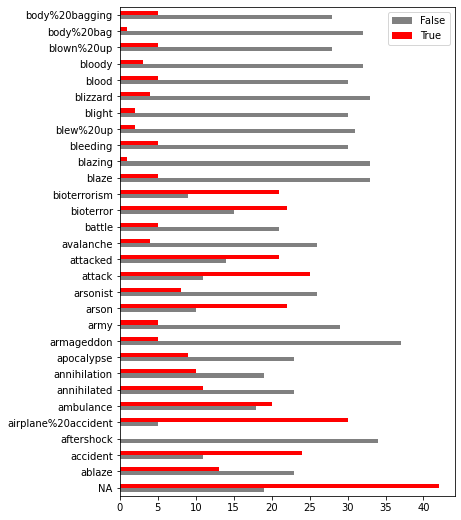

In [6]:
#%% Data cleaning. Structuring keyword vs target

train_df_original['keyword'].replace(np.nan, 'NA', inplace = True)
classes = set(train_df_original['keyword'])
classes = list(classes)

Zeros = []
Ones = []

for x in classes:
  class_x = train_df_original[train_df_original['keyword'] == x]
  zeros = len(class_x[class_x['target'] == 0])
  ones = len(class_x[class_x['target'] == 1])

  Zeros.append(zeros)
  Ones.append(ones)

  Table = [Zeros , Ones]

#keyword_df = pd.DataFrame([classes, Zeros, Ones], index = ['Keywords','Zeros','Ones'])
keyword_df = pd.DataFrame(Table, columns = classes, index = ['False','True'])
keyword_df = keyword_df.transpose()

keyword_df = keyword_df.sort_index()
keyword_df[:30].plot.barh(figsize = (6,9), color = ['gray','red'])

Text(0.5, 0, 'Number of tweets')

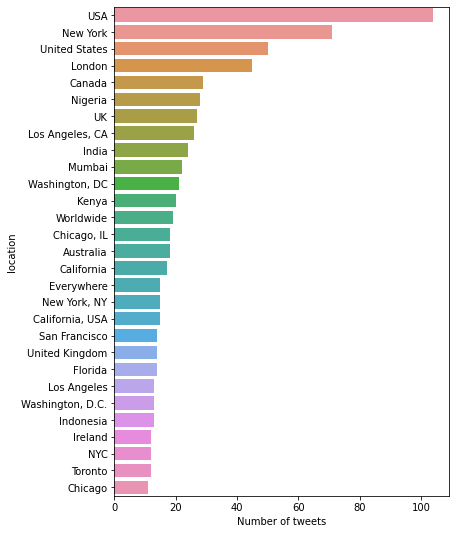

In [7]:
# Location visualization

train_df_original['location'].replace(np.nan, 'Unknown', inplace = True)
top_30 = train_df_original.groupby(['location']).count().text.sort_values(ascending = False)[1:30]

plt.figure(figsize = (6,9))
sns.barplot(x = top_30 , y = top_30.index);
plt.xlabel('Number of tweets')

## Task 2.2: Data Training and testing set partition

1. Creating training and validation sets
2. Implementation of cleaning/lemmatization function for tweets 
3. Extracting cleaned tweets and labels from the training partition

In [8]:
# Data partition

train_df, test_df = train_test_split(train_df_original, test_size=0.1, random_state=40, shuffle=True)
print('Original data training size:',train_df_original.shape)
print('Training partition:',train_df.shape)
print('Test partition:',test_df.shape)


Original data training size: (7613, 5)
Training partition: (6851, 5)
Test partition: (762, 5)


In [9]:
train_df = train_df.sort_values(by = ['id'])
train_df.head()

,id,keyword,location,text,target
0,1,NA,Unknown,Our Deeds are the Reason of this #earthquake M...,1
2,5,NA,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,NA,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,NA,Unknown,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NA,Unknown,#RockyFire Update => California Hwy. 20 closed...,1


In [10]:
test_df = test_df.sort_values(by = ['id'])
test_df.head()

,id,keyword,location,text,target
1,4,NA,Unknown,Forest fire near La Ronge Sask. Canada,1
28,40,NA,Unknown,Cooool :),0
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
45,65,ablaze,Unknown,I gained 3 followers in the last week. You? Kn...,0
52,76,ablaze,Barbados,SANTA CRUZ ÛÓ Head of the St Elizabeth Police...,0


In [11]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from nltk import word_tokenize
import regex as re

def get_clean_tweets(data, lem = True):
  # Replacing NaN
  data['keyword'].replace(np.nan,'NA', inplace = True)
  data['location'].replace(np.nan,'Unknown', inplace = True)
  # Concatenating keyword + text
  keywords = data['keyword']
  texts = data['text']
  tweets = list(keywords + ' ' + texts)
  # Lemmatizer and cleaning
  if lem == True:
    lemma = WordNetLemmatizer()
    lemmatized = []
    for x in range(len(tweets)):
      sentence = tweets[x]
      sentence = re.sub('[!@#=?&-<>]',"",sentence)
      sentence = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', sentence)
      sentence_lemma = ' '.join([lemma.lemmatize(sentence) for sentence in word_tokenize(sentence)])
      lemmatized.append(sentence_lemma)
    tweets = lemmatized
  # If 'target' label exists
  if 'target' in data.columns:
    labels = np.array(data['target'])
    return tweets , labels
  else:
    return tweets

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
# Data format with no cleaning
tweets , labels = get_clean_tweets(train_df , lem = False)
tweets[0:10] , labels[0:3]

(['NA Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
  "NA All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
  'NA 13,000 people receive #wildfires evacuation orders in California ',
  'NA Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
  'NA #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
  'NA #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
  "NA I'm on top of the hill and I can see a fire in the woods...",
  "NA There's an emergency evacuation happening now in the building across the street",
  "NA I'm afraid that the tornado is coming to our area...",
  'NA Three people died from the heat wave so far'],
 array([1, 1, 1]))

In [13]:
# Data type with cleaning and lemmatization
tweets , labels = get_clean_tweets(train_df , lem = True)
tweets[0:10] , labels[0:3]

(['NA Our Deeds are the Reason of this earthquake May ALLAH Forgive u all',
  'NA All resident asked to shelter in place are being notified by officer No other evacuation or shelter in place order are expected',
  'NA people receive wildfire evacuation order in California',
  'NA Just got sent this photo from Ruby Alaska a smoke from wildfire pours into a school',
  'NA RockyFire Update California Hwy closed in both direction due to Lake County fire CAfire wildfire',
  'NA flood disaster Heavy rain cause flash flooding of street in Manitou Colorado Springs area',
  'NA Im on top of the hill and I can see a fire in the wood',
  'NA Theres an emergency evacuation happening now in the building across the street',
  'NA Im afraid that the tornado is coming to our area',
  'NA Three people died from the heat wave so far'],
 array([1, 1, 1]))

In [14]:
print('train_tweets shape:', type(tweets))
print('train_labels shape:', labels.shape, type(labels))

train_tweets shape: <class 'list'>
train_labels shape: (6851,) <class 'numpy.ndarray'>


## Task 3: Tokenization

1. Tokenizing the training tweets

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(num_words = 15000 , oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [17]:
print(tweets[0])
print(labels[0])
tokenizer.texts_to_sequences([tweets[0]])

NA Our Deeds are the Reason of this earthquake May ALLAH Forgive u all
1


[[93, 130, 3989, 23, 2, 651, 6, 20, 157, 150, 1533, 3990, 85, 37]]

## Task 4: Padding and Truncating Sequences

1. Displaying the length of the training tweets
2. Creating padded sequences

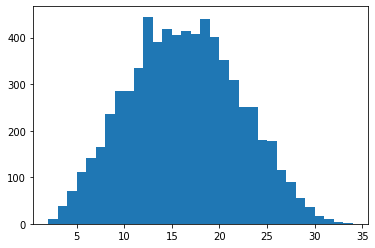

In [18]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths , bins = len(set(lengths)))
plt.show()

In [19]:
maxlen = 30
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
def get_sequences(tokenizer , tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences , truncating='post' , padding='post' , maxlen=maxlen)
  return padded

In [21]:
padded_train_seq = get_sequences(tokenizer , tweets)

print(tweets[0])
print(labels[0])
print(tokenizer.texts_to_sequences([tweets[0]]))
padded_train_seq[0]

NA Our Deeds are the Reason of this earthquake May ALLAH Forgive u all
1
[[93, 130, 3989, 23, 2, 651, 6, 20, 157, 150, 1533, 3990, 85, 37]]


array([  93,  130, 3989,   23,    2,  651,    6,   20,  157,  150, 1533,
       3990,   85,   37,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [22]:
print(padded_train_seq.shape)

(6851, 30)


## Task 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [23]:
classes = set(labels)
classes

{0, 1}

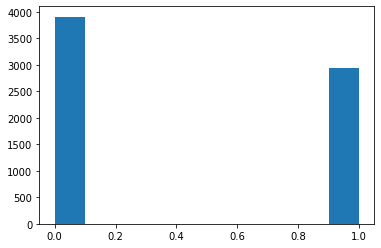

In [24]:
plt.hist(labels , bins = 10)
plt.show()

In [25]:
print(labels.shape)
labels[0:10]

(6851,)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Task 6: Creating the Model

1. Creating the model and compiling the model

In [26]:
model = tf.keras.models.Sequential([
                                   tf.keras.layers.Embedding(15000, 100, input_length = maxlen),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
                                   tf.keras.layers.Dropout(0.5),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                   tf.keras.layers.Dense(1, activation = 'sigmoid')
                                  ])

model.compile(
              loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           84480     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,625,761
Trainable params: 1,625,761
Non-trainable params: 0
_________________________________________________________________


## Task 7: Training the Model

1. Preparing the validation set
2. Training the model

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(padded_train_seq, labels, test_size = 0.1, 
                                                      random_state = 1, shuffle = True)
print('X_train shape:',X_train.shape, type(X_train))
print('y_train shape:',y_train.shape, type(y_train))

print('X_valid shape:',X_valid.shape, type(X_valid))
print('y_valid shape:',y_valid.shape, type(y_valid))

X_train shape: (6165, 30) <class 'numpy.ndarray'>
y_train shape: (6165,) <class 'numpy.ndarray'>
X_valid shape: (686, 30) <class 'numpy.ndarray'>
y_valid shape: (686,) <class 'numpy.ndarray'>


In [28]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_train , y_train = sm.fit_resample(X_train , y_train)

print('Balanced X_train shape:',X_train.shape, type(X_train))
print('Balanced y_train shape:',y_train.shape, type(y_train))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Balanced X_train shape: (7034, 30) <class 'numpy.ndarray'>
Balanced y_train shape: (7034,) <class 'numpy.ndarray'>


In [49]:
callbacks = [
    EarlyStopping(patience = 8, verbose = 1),
    ReduceLROnPlateau(factor = 0.1, patience = 2, min_lr = 0.0001, verbose = 1),
    ModelCheckpoint('model-tweetNLP.h5', verbose = 1, save_best_only = True, save_weights_only = False)
    ]

h = model.fit(X_train, y_train,
              validation_data = (X_valid, y_valid),
              epochs = 10,
              callbacks = callbacks
              )

Epoch 1/10
220/220 [==============================] - 3s 12ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.8656 - val_accuracy: 0.7872

Epoch 00001: val_loss improved from inf to 0.86556, saving model to model-tweetNLP.h5
Epoch 2/10
220/220 [==============================] - 3s 12ms/step - loss: 0.0445 - accuracy: 0.9854 - val_loss: 0.9042 - val_accuracy: 0.7872

Epoch 00002: val_loss did not improve from 0.86556
Epoch 3/10
220/220 [==============================] - 3s 12ms/step - loss: 0.0410 - accuracy: 0.9881 - val_loss: 0.9294 - val_accuracy: 0.7857

Epoch 00003: val_loss did not improve from 0.86556
Epoch 4/10
220/220 [==============================] - 3s 12ms/step - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.9127 - val_accuracy: 0.7872

Epoch 00004: val_loss did not improve from 0.86556
Epoch 5/10
220/220 [==============================] - 3s 12ms/step - loss: 0.0365 - accuracy: 0.9881 - val_loss: 0.9405 - val_accuracy: 0.7770

Epoch 00005: val_loss did not improve fro

## Task 8: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

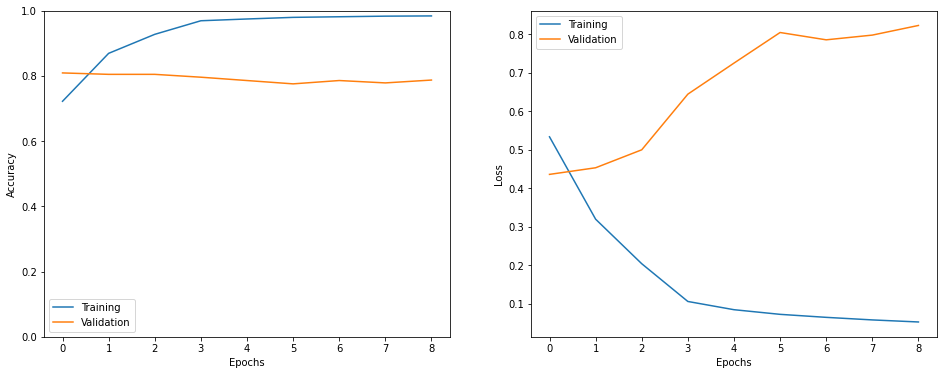

In [30]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [31]:
test_tweets , test_labels = get_clean_tweets(test_df, lem=True)
test_seq = get_sequences(tokenizer , test_tweets)

test_tweets[0:3] , test_labels[0:3]

(['NA Forest fire near La Ronge Sask Canada',
  'NA Cooool',
  'ablaze We always try to bring the heavy metal RT httptcoYAoexngw'],
 array([1, 0, 0]))

In [32]:
print('test_tweets shape:', type(test_tweets))
print('test_labels shape:', test_labels.shape, type(test_labels))

test_tweets shape: <class 'list'>
test_labels shape: (762,) <class 'numpy.ndarray'>


In [33]:
_ = model.evaluate(test_seq , test_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.9220 - accuracy: 0.7585


In [34]:
# Prediction on a random test tweet 

i = random.randint(0 , len(test_labels) - 1)

print('Tweet:' , test_tweets[i])
print('Emergency:' , test_labels[i])
#print('Tokenized tweet:' , test_seq[i])

p = model.predict(test_seq[i])[0]
pred_class = np.array( (p > 0.5).astype(np.uint8) )

print('Predicted emergency:' , pred_class)

Tweet: lightning Lightning strike in the distance via rpics httptcoiDmhSwewQw pic
Emergency: 1
Predicted emergency: [0]


In [35]:
# Prediction on the test tweet dataset

p = model.predict(test_seq)
preds = np.array( (p > 0.5).astype(np.uint8) )

print(p.shape)
print(preds.shape)

(762, 1)
(762, 1)


In [36]:
total = len(test_labels)
test_labels_expanded = np.expand_dims(test_labels , axis = 1)
failed = np.sum(np.abs( test_labels_expanded - preds))

total , failed

(762, 184)

CM = [[0.79214781 0.20785219]
 [0.28571429 0.71428571]]


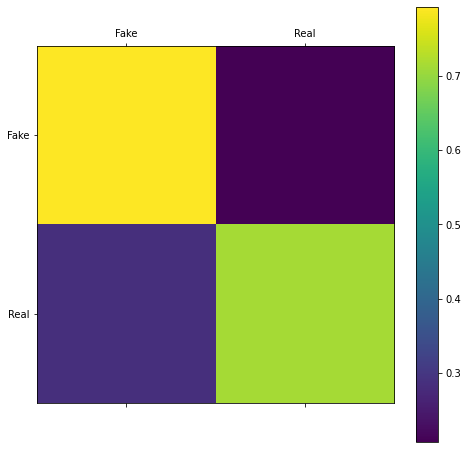

In [37]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 2)), labels=classes)
    plt.yticks(list(range(0, 2)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


from sklearn.metrics import confusion_matrix
Confusion_M = confusion_matrix(test_labels_expanded , preds , normalize='true')
print("CM =", Confusion_M)  

tags = ['Fake', 'Real']
show_confusion_matrix(test_labels_expanded , preds , tags)

## Task 9: Evaluating for submitting

1. Assessing new data for submission in Kaggle platform

In [38]:
submission_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [39]:
subm_tweets = get_clean_tweets(submission_df,lem=True)
subm_seq = get_sequences(tokenizer , subm_tweets)

subm_tweets[0:3], subm_seq[0:3]

(['NA Just happened a terrible car crash',
  'NA Heard about earthquake is different city stay safe everyone',
  'NA there is a forest fire at spot pond goose are fleeing across the street I can not save them all'],
 array([[  93,   29,  789,    3, 2173,  128,   83,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  93,  529,   58,  157,    9, 1222,  298,  594, 2064,  373,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [  93,   71,    9,    3,  111,   16,   18,  774, 3962,    1,   23,
         4459,  825,    2,  537,    7,   81,   34,  518,  121,   37,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32))

In [40]:
p_subm = model.predict(subm_seq)
preds_subm = np.array( (p_subm > 0.5).astype(np.uint8) )

print(preds_subm.shape)

(3263, 1)


In [41]:
index_subm = np.array(submission_df['id']) 
print(index_subm.shape)
submission = pd.DataFrame({ "id": index_subm, "target": np.squeeze(preds_subm) })
submission.head()

(3263,)


,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [42]:
submission.to_csv("submission_LSTM.csv", index=False)

## Task 10. Save and load the model for deployment

1. Load model
2. Make predictions with loaded model on random test data

In [50]:
from keras.models import load_model

model_NLP = load_model('/content/model-tweetNLP.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           84480     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,625,761
Trainable params: 1,625,761
Non-trainable params: 0
_________________________________________________________________


In [53]:
i = random.randint(0 , len(test_labels) - 1)

print('Tweet:' , test_tweets[i])
print('Emergency:' , test_labels[i])
#print('Tokenized tweet:' , test_seq[i])

p = model_NLP.predict(test_seq[i])[0]
pred_class = np.array( (p > 0.5).astype(np.uint8) )

print('Predicted emergency:' , pred_class)

Tweet: bridge % collapse ameenshaikh sir i just only wanted to make a point about sureshpprabhu you made and said he is lying about bridge collapse
Emergency: 1
Predicted emergency: [1]
